In [1]:
import pickle
import pandas as pd
import numpy as np
import pytds
import psycopg2
import math
import joblib
import os
from boltons import statsutils
from pdpbox import pdp, get_dataset, info_plots
import seaborn as sns
from statsmodels.robust.scale import huber, Huber
from datetime import datetime, timedelta
from copy import deepcopy
from numpy import mean, median
import pandas_profiling as pp
import gc
import pyodbc
from numpy import mean, median
import warnings
import itertools
warnings.filterwarnings('ignore')
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import binom_test
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data_folder = '../'

In [3]:
train_transaction = pd.read_csv(data_folder+'train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv(data_folder+'test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv(data_folder+'train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv(data_folder+'test_identity.csv', index_col='TransactionID')

In [4]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [5]:
del train_transaction
del test_transaction
del train_identity
del test_identity

In [6]:
mean_amt = pd.concat([train[['TransactionAmt']],test[['TransactionAmt']]])['TransactionAmt'].mean()

train['is_bigger_mean'] = (train['TransactionAmt']>mean_amt).astype(int)
test['is_bigger_mean'] = (test['TransactionAmt']>mean_amt).astype(int)

In [7]:
tmp = pd.crosstab(train['is_bigger_mean'], train['isFraud'], normalize='index')*100

In [8]:
tmp

isFraud,0,1
is_bigger_mean,,
0,96.802425,3.197575
1,95.550366,4.449634


In [9]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 
          'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [10]:
bin_to_num_dict = {'google':1, 'microsoft':2, 'other':3, 'yahoo':4, 'None':0}
suf_to_num_dict = {'com':1, 'nan':2, 'us':3}

In [11]:
def is_same_email_bin(P_email, R_email):
    P_email = str(P_email)
    R_email = str(R_email)
    if (R_email=='nan' and P_email=='nan'):
        return 1
    elif (R_email=='nan'):
        return 2
    elif (P_email=='nan'):
        return 3
    elif (P_email==R_email):
        return 4
    else:
        return 0

In [12]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails).fillna('nan')
    test[c + '_bin'] = test[c].map(emails).fillna('nan')
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [13]:
train['is_same_email_bin'] = train[['P_emaildomain_bin', 'R_emaildomain_bin']].apply(lambda r: is_same_email_bin(r['P_emaildomain_bin'],r['R_emaildomain_bin']), axis=1)
test['is_same_email_bin'] = test[['P_emaildomain_bin', 'R_emaildomain_bin']].apply(lambda r: is_same_email_bin(r['P_emaildomain_bin'],r['R_emaildomain_bin']), axis=1)

train['is_same_email_suf'] = train[['P_emaildomain_suffix', 'R_emaildomain_suffix']].apply(lambda r: is_same_email_bin(r['P_emaildomain_suffix'],r['R_emaildomain_suffix']), axis=1)
test['is_same_email_suf'] = test[['P_emaildomain_suffix', 'R_emaildomain_suffix']].apply(lambda r: is_same_email_bin(r['P_emaildomain_suffix'],r['R_emaildomain_suffix']), axis=1)

In [14]:
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c + '_bin'].map(bin_to_num_dict).fillna(5)
    test[c + '_bin'] = test[c + '_bin'].map(bin_to_num_dict).fillna(5)
    
    train[c + '_suffix'] = train[c + '_suffix'].map(suf_to_num_dict).fillna(4)
    test[c + '_suffix'] = test[c + '_suffix'].map(suf_to_num_dict).fillna(4)

In [15]:
train.groupby('P_emaildomain_bin', as_index=False)['isFraud'].mean().sort_values('isFraud')

,P_emaildomain_bin,isFraud
3,4.0,0.022052
2,3.0,0.025914
4,5.0,0.026834
0,1.0,0.043496
1,2.0,0.053298


In [16]:
def plot_categorical_feature(df, feature, target):
    temp_bad = df.loc[df[target]==1]
    temp_bad = temp_bad.groupby(feature, as_index=False)[target].count()
    temp_good = df.loc[df[target]==0]
    temp_good = temp_good.groupby(feature, as_index=False)[target].count()
    temp = temp_good.merge(temp_bad, on=feature, suffixes=('_g', '_b'))
    temp['perc'] = round(100*temp[target+'_b']/(temp[target+'_b']+temp[target+'_g']),2)
    trace_1 = go.Bar(x = temp_good[feature], y=temp_good[target], name='Хорошие')
    trace_2 = go.Bar(x = temp_bad[feature], y=temp_bad[target], name='Плохие', text=temp.perc, textposition = 'auto')
    layout = go.Layout(barmode='stack')
    fig = go.Figure(data=[trace_1, trace_2], layout=layout)
    iplot(fig)

In [17]:
plot_categorical_feature(train, 'is_same_email_bin', 'isFraud')

In [18]:
def time_num_feature_plot():
    pass

def bad_good_distplot(train, feature):
    fig = plt.gcf()
    fig.set_size_inches(12.5, 8)
    sns.distplot(train[(train.isFraud==0)][feature],fit_kws=False, kde=True)
    sns.distplot(train[(train.isFraud==1)][feature],fit_kws=False, kde=True)
    plt.legend(labels=['Fraud', 'Normal'])

In [19]:
train.R_emaildomain_bin.value_counts()/len(train)<0.02

5.0    False
1.0    False
2.0    False
3.0    False
4.0    False
Name: R_emaildomain_bin, dtype: bool

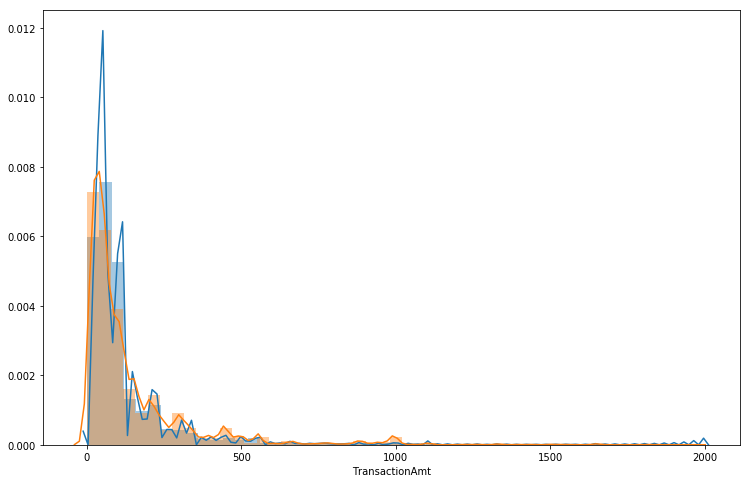

In [20]:
fig = plt.gcf()
fig.set_size_inches(12.5, 8)
sns.distplot(train[(train.isFraud==0)&(train.TransactionAmt<2000)]['TransactionAmt'])
sns.distplot(train[(train.isFraud==1)&(train.TransactionAmt<2000)]['TransactionAmt'])

In [21]:
test.TransactionAmt.describe()

count    506691.000000
mean        134.725568
std         245.779822
min           0.018000
25%          40.000000
50%          67.950000
75%         125.000000
max       10270.000000
Name: TransactionAmt, dtype: float64

In [22]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

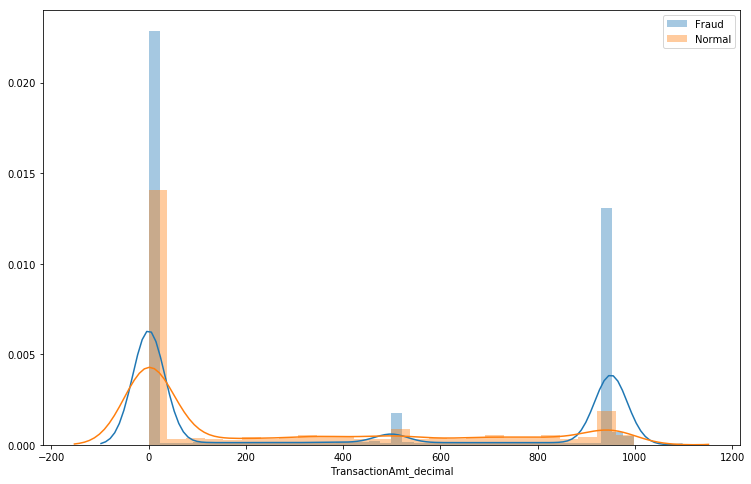

In [23]:
bad_good_distplot(train,'TransactionAmt_decimal')

In [24]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'is_bigger_mean', 'TransactionDT', 
                   'R_emaildomain_suffix', 'R_emaildomain_bin', 
                   'P_emaildomain_suffix', 'P_emaildomain_bin', 'TransactionAmt_decimal']

In [25]:
drop_features = [col for col in train.columns if col not in useful_features]
#drop_features.remove('isFraud')

In [26]:
# useful_train = train[useful_features+['isFraud']]
# useful_test = test[useful_features]

In [27]:
train.shape

(590540, 441)

In [28]:
#useful_train.card4.isnull().sum()

In [29]:
train.card6.value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [30]:
train.TransactionAmt.isnull().sum()

0

In [31]:
card_1_count = train.groupby('card1')['TransactionAmt'].transform('count')

In [32]:
train['card1_count'] = card_1_count

In [33]:
train['card1_count'].value_counts()

14932    14932
14162    14162
10361    10361
10344    10344
7945      7945
7091      7091
6773      6773
6771      6771
6141      6141
5334      5334
5172      5172
5129      5129
4614      4614
4410      4410
4209      4209
4158      4158
3977      3977
3929      3929
3873      3873
3748      3748
3693      3693
3560      3560
3490      3490
1         3444
2         3380
3         3312
4         3212
3166      3166
3152      3152
5         3110
         ...  
236        236
118        236
235        235
116        232
225        225
218        218
217        217
211        211
210        210
203        203
190        190
189        189
188        188
186        186
181        181
174        174
173        173
169        169
167        167
164        164
154        154
150        150
149        149
144        144
140        140
136        136
131        131
119        119
113        113
103        103
Name: card1_count, Length: 517, dtype: int64

In [34]:
train.dist2.isnull().sum(), train.shape

(552913, (590540, 442))

In [35]:
for feat in useful_features:
    if train[feat].isnull().sum()==0:
        print(feat, test[feat].isnull().sum())

TransactionAmt 0
ProductCD 0
card1 0
C1 3
C2 3
C4 3
C5 3
C6 3
C7 3
C8 3
C9 3
C10 3
C11 3
C12 3
C13 4748
C14 3
is_bigger_mean 0
TransactionDT 0
R_emaildomain_suffix 0
R_emaildomain_bin 0
P_emaildomain_suffix 0
P_emaildomain_bin 0
TransactionAmt_decimal 0


In [36]:
test[test.C1.isnull()][['C1','C3', 'C4','C7', 'C8']]

,C1,C3,C4,C7,C8
TransactionID,,,,,
4032462,NaN,NaN,NaN,NaN,NaN
4032486,NaN,NaN,NaN,NaN,NaN
4032489,NaN,NaN,NaN,NaN,NaN


In [48]:
train['amt_product_mean']=train['TransactionAmt']/train.groupby('card1')['TransactionAmt'].transform('mean')

In [49]:
train[['isFraud', 'amt_product_mean']].groupby('isFraud')['amt_product_mean'].mean()

isFraud
0    0.993358
1    1.183173
Name: amt_product_mean, dtype: float64

In [50]:
train.amt_product_mean.mean(), train.amt_product_mean.std()

(1.0000000000000198, 1.3662192705886542)

In [41]:
a = train.groupby('ProductCD', as_index=False)['TransactionAmt'].mean()
a.rename({'TransactionAmt':'amt_product_mean'}, axis=1, inplace=True)

In [42]:
train_2 = train[['ProductCD', 'TransactionAmt']].merge(a, how='left', on=['ProductCD'])

In [54]:
a = pd.concat([train[['TransactionAmt']], test[['TransactionAmt']]])

In [57]:
a.loc[train.index]

,TransactionAmt
TransactionID,
2987000,68.500
2987001,29.000
2987002,59.000
2987003,50.000
2987004,50.000
2987005,49.000
2987006,159.000
2987007,422.500
2987008,15.000


In [58]:
for f in list(test.columns):
    if train[f].dtype=='object' or test[f].dtype=='object': 
        print(f)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [88]:
train.DeviceInfo.value_counts()

Windows                           47722
iOS Device                        19782
MacOS                             12573
Trident/7.0                        7440
rv:11.0                            1901
rv:57.0                             962
SM-J700M Build/MMB29K               549
SM-G610M Build/MMB29K               461
SM-G531H Build/LMY48B               410
rv:59.0                             362
SM-G935F Build/NRD90M               334
SM-G955U Build/NRD90M               328
SM-G532M Build/MMB29T               316
ALE-L23 Build/HuaweiALE-L23         312
SM-G950U Build/NRD90M               290
SM-G930V Build/NRD90M               274
rv:58.0                             269
rv:52.0                             256
SAMSUNG                             235
SM-G950F Build/NRD90M               225
Moto G (4) Build/NPJ25.93-14.7      219
SM-N950U Build/NMF26X               209
SM-A300H Build/LRX22G               203
hi6210sft Build/MRA58K              190
SM-J730GM Build/NRD90M              184


In [97]:
train.addr1.isnull().sum()

65706

In [99]:
np.corrcoef(train.card2, train.card5)

array([[nan, nan],
       [nan, nan]])

In [119]:
train['huy'] = (train.card2.fillna(-999).astype(int).astype(str) + train.card5.fillna(-999).astype(int).astype(str)).factorize()[0]

In [110]:
train.card5.value_counts()

226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
138.0     19737
195.0     16945
137.0     11720
126.0     10298
219.0      9924
202.0      7103
162.0      4524
229.0      2048
197.0      1551
150.0      1338
100.0       978
223.0       936
118.0       752
190.0       744
146.0       671
198.0       670
236.0       647
185.0       474
203.0       428
147.0       417
141.0       341
129.0       325
142.0       277
194.0       259
183.0       258
          ...  
172.0         3
216.0         3
231.0         2
140.0         2
113.0         2
191.0         2
145.0         2
205.0         2
200.0         2
152.0         2
123.0         2
160.0         2
105.0         2
115.0         1
120.0         1
206.0         1
209.0         1
196.0         1
201.0         1
125.0         1
187.0         1
165.0         1
221.0         1
181.0         1
178.0         1
175.0         1
173.0         1
167.0         1
234.0         1
204.0         1
Name: card5, Length: 119

## M1-M9 features wtf?

In [10]:
train[train.M1==1][['card1','card2','card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']]

,card1,card2,card3,card4,card5,card6,addr1,addr2
TransactionID,,,,,,,,


In [17]:
train.M1.value_counts(), train['M1'].isnull().sum()

(T    319415
 F        25
 Name: M1, dtype: int64, 271100)

In [19]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    print(col, train[col].isnull().sum())
    print(train[col].value_counts())
    print('-'*50)

M1 271100
T    319415
F        25
Name: M1, dtype: int64
--------------------------------------------------
M2 271100
T    285468
F     33972
Name: M2, dtype: int64
--------------------------------------------------
M3 271100
T    251731
F     67709
Name: M3, dtype: int64
--------------------------------------------------
M4 281444
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
--------------------------------------------------
M5 350482
F    132491
T    107567
Name: M5, dtype: int64
--------------------------------------------------
M6 169360
F    227856
T    193324
Name: M6, dtype: int64
--------------------------------------------------
M7 346265
F    211374
T     32901
Name: M7, dtype: int64
--------------------------------------------------
M8 346252
F    155251
T     89037
Name: M8, dtype: int64
--------------------------------------------------
M9 346252
T    205656
F     38632
Name: M9, dtype: int64
--------------------------------------------------


In [20]:
train['M1M2M3'] = train['M1'].fillna('N') + train['M2'].fillna('N') + train['M3'].fillna('N')

In [25]:
train['M1M2M3'] = train['M1M2M3'].apply(lambda x: 'FFF' if 'F' in x else x)

In [26]:
train.groupby('M1M2M3')['isFraud'].mean()

M1M2M3
FFF    0.030262
NNN    0.052826
TTT    0.017054
Name: isFraud, dtype: float64

TransactionID
2987000    TTT
2987001    NNN
2987002    TTT
2987003    NNN
2987004    NNN
2987005    TTT
2987006    TTT
2987007    NNN
2987008    NNN
2987009    TTT
2987010    NNN
2987011    NNN
2987012    NNN
2987013    NNN
2987014    NNN
2987015    TTF
2987016    NNN
2987017    NNN
2987018    TTF
2987019    NNN
2987020    TTT
2987021    NNN
2987022    NNN
2987023    TTT
2987024    NNN
2987025    NNN
2987026    NNN
2987027    TTF
2987028    NNN
2987029    NNN
          ... 
3577510    TFF
3577511    TTT
3577512    TTT
3577513    TTT
3577514    TFF
3577515    TTT
3577516    TTT
3577517    TTT
3577518    TTF
3577519    TTT
3577520    TTT
3577521    NNN
3577522    TTT
3577523    NNN
3577524    TFF
3577525    TTT
3577526    NNN
3577527    TFF
3577528    TFF
3577529    NNN
3577530    NNN
3577531    NNN
3577532    TTT
3577533    TTT
3577534    NNN
3577535    TTT
3577536    TFF
3577537    TFF
3577538    TTT
3577539    TFF
Name: M1M2M3, Length: 590540, dtype: object